# Word Embeddings (IMDB Dataset)


## This tutorial contains an introduction to word embeddings. You will train your own word embeddings using a simple Keras model for a sentiment classification task, and then visualize them in the [Embedding Projector](https://projector.tensorflow.org/?_gl=1*7b3ljy*_ga*MjEzNjQ0MjMzMy4xNzI2NzU2MDg3*_ga_W0YLR4190T*MTcyNzAxODU5OC44LjAuMTcyNzAxODU5OC4wLjAuMA..)



### Representing text as numbers
    - you will look at three strategies for doing so:
        1. One-hot encoding
        2. Encode each word with a unique number
        3. Word embeddings
![image](https://www.tensorflow.org/static/text/tutorials/images/one-hot.png)

        - A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

        - Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify).

![image](https://www.tensorflow.org/static/text/tutorials/images/embedding2.png)


## Setup

In [2]:
import io
import os
import shutil
import string
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

## Download the IMDB dataset


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 173s 2us/step


['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [44]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
# The train directory also has additional folders which should be removed before creating training dataset.

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [45]:
# Use the train directory to create both train and validation datasets with a split of 20% for validation.

batch_size = 1024
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size, validation_split = 0.2,
    subset = 'training', seed = seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset = 'validation', seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [46]:
# Take a look at a few movie reviews and their labels (1: positive, 0: negative) from the train dataset.

for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

1 b'David Lynch usually makes films that resemble puzzles put together the wrong way. They are interesting to look at and think about but they really don\'t gel in your mind. Perhaps art will always mean the most to its creator.<br /><br />The Straight Story is not a typical David Lynch film. Not that there\'s anything typical about them anyway. It\'s an odyssey through rural America. A real life journey Alvin Straight took on a lawn mower to get to his brothers house. He rode 300 miles from Laurens, Iowa to Mt. Zion, Wisconsin to make amends to his sick brother for past offenses.<br /><br />At the heart of this film is sweet voiced Richard Farnsworth. He brings Alvin Straight right to us in a simple and honest way. The fact that the film is slow paced matches Alvin\'s slow journey toward realization.<br /><br />Along the way Alvin meets a confused and frightened young girl. She is pregnant and has decided to run away from her situation. After listening to Alvin speak about family she 

## Configure the dataset for performance

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Embedding layer


        The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [48]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

## Text Preprocessing


        define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews.

In [49]:
# Create a custom standardization function to strip HTML break tags '<br />'.
import re

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = sequence_length)

In [50]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

## Classification model


In this case it is a "Continuous bag of words" style model.

        The TextVectorization layer 
        The Embedding layer
        The GlobalAveragePooling1D
        fully-connected (Dense) layer
        last layer is densely connected with a single output node.



In [51]:
tf.random.set_seed(123)

embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name = "embedding", mask_zero=True),
  tf.keras.layers.LSTM(16),
  Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  Dense(16, activation='relu'),
  Dense(1)
])
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

with tf.device('GPU'):
    history = model.fit(train_ds, validation_data = val_ds, epochs = 15)

Epoch 1/15


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 473ms/step - accuracy: 0.5044 - loss: 0.6930 - val_accuracy: 0.4886 - val_loss: 0.6919
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.5044 - loss: 0.6900 - val_accuracy: 0.4886 - val_loss: 0.6746
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.5709 - loss: 0.6386 - val_accuracy: 0.7890 - val_loss: 0.5119
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.8000 - loss: 0.4712 - val_accuracy: 0.8098 - val_loss: 0.4378
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.8606 - loss: 0.3518 - val_accuracy: 0.7988 - val_loss: 0.4694
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.8842 - loss: 0.3059 - val_accuracy: 0.8298 - val_loss: 0.4428
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.8817 - loss: 0.2996 - val_accuracy: 0.8200 - val_loss: 0.4121
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.9028 - loss: 0.2602 - val_accuracy: 0.8258 - val

In [53]:
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,773 (1.88 MB)

 Trainable params: 164,257 (641.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 328,516 (1.25 MB)

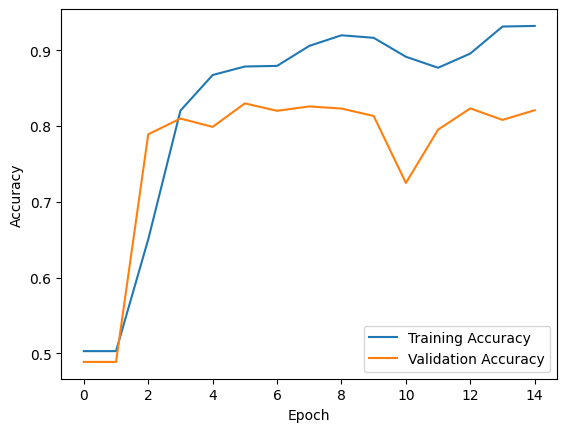

In [52]:
# plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Retrieve the trained word embeddings and save them to disk

In [54]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding = 'utf-8')
out_m = io.open('metadata.tsv', 'w', encoding ='utf-8')
 
for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

## Visualize the embeddings

- To visualize the embeddings, upload them to the embedding projector.

        Open the Embedding Projector (this can also run in a local TensorBoard instance).

        Click on "Load data".

        Upload the two files you created above: vecs.tsv and meta.tsv.

![image](Screenshot 2024-09-22 220233.png)
